# Project

**Authors:** 
* Jørgen Baun Høst, pjz633@alumni.ku.dk
* Marius Heltberg Lassen, pgb206@alumni.ku.dk

This notebook contains the data extraction, data structuring and manipulation, calculations and figures for our project *Liar, liar, pants on fire? Fake news detection with supervised machine learning*.

Dependencies:

In [1]:
# %pip install

Imports and set magics:

In [2]:
import numpy as np
import pandas as pd
import tqdm
import time
import datetime
import os
import requests
from bs4 import BeautifulSoup
import json
import re

import matplotlib.pyplot as plt 
import seaborn as sns

plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [3]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams['figure.figsize'] = 10, 4 # set default size of plots

## Web scraping 

### Define functions:

General functions:

In [4]:
def log(response: requests.Response):
    """
    Creates or appends a log-file with information from a `requests.get()`-call.
    
    The information gathered is:
    - - - - - - - -
        timestamp   :   Current local time.
        status_code :   Status code from requests call.
        length      :   Length of the HTML-string.
        output_path :   Current working directory.
        url         :   The URL of the response.
    """

    # Open or create the csv file
    if os.path.isfile('log'):
        log = open('log','a')
    else: 
        log = open('log','w')
        header = ['timestamp', 'status_code', 'length', 'output_file', 'url'] # Header names
        log.write(';'.join(header) + "\n")
        
    # Gather log information
    status_code = response.status_code # Status code from the request result
    timestamp = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())) # Local time
    length = len(response.text) # Length of the HTML-string
    output_path = os.getcwd() # Output path
    url = response.url # URL-string
    
    # Open the log file and append the gathered log information
    with open('log','a') as log:
        log.write(f'{timestamp};{status_code};{length};{output_path};{url}' + "\n") 


def get_soup(url: str, header: dict) -> BeautifulSoup:
    """
    Constructs a HTML-string from a request of the given URL. 
    Requests are logged, see `log()`. 

    Input:
    - - - - - - - - 
    url (str)     :    URL of the website to receive the HTML-string from. \n
    header (dict) :    Dictionary to send in the query string for the request.

    Returns:
    - - - - - - - - 
    soup (BeautifulSoup) :  HTML-string in the class of BeutifulSoup with 'lxml' parser.
    """

    response = requests.get(url, headers=header) # Request
    log(response) # Log 
    soup = BeautifulSoup(response.content, 'lxml') # Convert to response to HTML

    return soup


def extract_articles_pf_pages(soup: BeautifulSoup) -> list:
    """
    Extracts articles from HTML-string from the PolitiFact website.

    Input:
    - - - - - - - -
    soup (BeautifulSoup) : HTML-string from the PolitiFact website.

    Returns:
    - - - - - - - - 
    list_of_articles (list) : A list of all articles in the given soup. \n
                              Each element is an article of data structure as BeautifulSoup.
    """
    
    articles = soup.find(class_='o-listicle__list') # Find section with articles
    list_of_articles = articles.find_all('li') # Find all articles as a list

    return list_of_articles

PolitiFact functions:

In [5]:
def create_url_pf_pages(page: int) -> str:
    """
    Creates a PolitiFact URL with the given pagenumber.

    Input:
    - - - - - - - -
    page (int) :    Pagenumber for the PolitiFact website.

    Returns:
    - - - - - - - -
    url (str)  :    URL of the PolitiFact website for given page. 
    """

    url = f'https://www.politifact.com/factchecks/list/?page={page}' # Construct url with f-string

    return url


def extract_info_pf_pages(article: BeautifulSoup) -> list:
    """
    Extracts all relevant information from one article on the article overview pages on the PolitiFact website.

    Input:
    - - - - - - - - 
    article (BeautifulSoup) :  Article to extract data from, see `extract_articles()`.

    Returns:
    - - - - - - - - 
    [name_txt, name_href, description_txt, quote_txt, quote_href, meter, footer] (list) \n 
    The name and URL of the quoted person, the description of the quote, the quote itself \n
    and link hereof, the truthfulness index, and information on the article in string-format.
    """

    # Statement name 
    name = article.find(class_='m-statement__name')
    name_txt = name.text # name 
    name_href = name['href'] # href

    # Statement description
    description_txt = article.find(class_='m-statement__desc').text

    # Statement quote
    quote = article.find(class_='m-statement__quote').a
    quote_txt = quote.text # name 
    quote_href = quote['href'] # href

    # Statement meter
    meter = article.find(class_='m-statement__meter').div.img['alt']

    # Statement footer
    footer = article.find(class_='m-statement__footer').text

    return [name_txt, name_href, description_txt, quote_txt, quote_href, meter, footer]


def data_pf_pages(startpage: int, endpage: int, header: dict, sleep: float) -> list:
    """
    Compound function that scrapes an interval of pages from PolitiFact, extracts information for analysis, \n
    and logs requests in `log`-file. 

    Input:
    - - - - - - - -
    startpage (int)  :  The first page to scrape. \n
    endpage   (int)  :  The last page to scrape. \n
    header    (dict) :  Dictionary to send in the query string for the request. \n
    sleep     (float):  Seconds to sleep between each request.

    Returns:
    - - - - - - - -
    list_of_output (list) : A list of lists, where each element list is the output of `extract_info()`.
    errors         (list) : An error list containing the URLs for the pages where the error occured.
    """

    list_of_output = [] # initialize empty list for dataframes
    errors = [] 

    # Loop through pages and track progress with tqdm
    for page in tqdm.tqdm(range(startpage, endpage+1)):
        url = create_url_pf_pages(page) # create url

        try: # circumvent problem with empty pages
            soup = get_soup(url, header) # construct html
            articles = extract_articles_pf_pages(soup) # extract articles 

            output = [] # initialize empty for articles 

            # Loop through articles 
            for article in articles:
                info = extract_info_pf_pages(article) # extract relevant information
                output.append(info) # append output
            time.sleep(sleep)

        except: # skip page
            print(f'Error encountered on page {page}')
            errors.append(url)
            time.sleep(sleep)
            continue

        list_of_output.append(output)

    return list_of_output, errors


def extract_info_pf_articles(article: BeautifulSoup) -> list:
    """
    A function that scrapes each individual article for relevant data. \n

    Input:
    - - - - - - - -
    article (BeautifulSoup) : BeatifulSoup element of article. \n
    
    Returns:
    - - - - - - - -
    [tags, sub_header, text_body] : A list of of all relevant data from each politifact article.

    """

    # Extract tags
    tag_soup = article.find(class_='m-list m-list--horizontal')\
        .find_all('a') #Find all tags
    
    list_of_tags = [] #Create empty list for tags 
    
    for tag in tag_soup:
        list_of_tags.append(tag['title']) #Append each tag to list of tags

    # Extract sub-header
    sub_header = article.find(class_='c-title c-title--subline').text #conclusion by journalist

    # Extract entire text body
    text_block = article.find(class_='m-textblock') #Find article's body text
    text_body = []

    for paragraph in text_block.find_all('p'): #Find all paragraphs in article
        text_body.append(paragraph.text) #append them to list

    text_body=' '.join(text_body) #Convert to a single string

    return [list_of_tags, sub_header, text_body]


def data_pf_articles(list_of_href: list, header: dict, sleep: float) -> list:
    """
    A compound function that scrapes relevant data from each article on politifact.com and stores this in a DataFrame. \n

    Input:
    - - - - - - - -
    list_of_href (list) :  A list of PolitiFact hyperlinks for each article to scrape. \n
    header       (dict) :  Dictionary to send in the query string for the request. \n
    sleep        (float):  Seconds to sleep between each request.
    
    Returns:
    - - - - - - - -
    list_of_output (list) : A list of lists, where each element list is the output of `get_article_data()` and the article href.
    errors         (list) : An error list containing the URLs for the pages where the error occured.
    """

    list_of_output = [] # Initialize empty output list 
    errors = []

    # Loop through list of URls
    for article_url in tqdm.tqdm(list_of_href): 
        full_url = 'https://www.politifact.com' + article_url
        try:   
            article = get_soup(full_url, header=header) #Get BeautifulSoup element for each article
            article_data = extract_info_pf_articles(article) #Extract data from article
            article_data.append(article_url) #Quote_href
            list_of_output.append([article_data]) #Append data to output list
            time.sleep(sleep)

        except: 
            print(f'Error encountered at {full_url}')
            errors.append(article_url)
            time.sleep(sleep)
            continue

    return list_of_output, errors

PeaceNet functions:

In [6]:
def extract_urls_pd_pages(list_of_frontpage_url: str, header: dict, sleep: float) -> list:
    set_of_article_url = set()
    errors = set()
    for frontpage_url in tqdm.tqdm(list_of_frontpage_url):
        soup = get_soup(frontpage_url, header)
        try:
            section = soup.find(class_='jeg_main')
            titles = section.findChildren(class_='jeg_thumb')
            for title in titles:
                article_url = title.a['href']
                set_of_article_url.add(article_url) #Same approach as above
                time.sleep(sleep)
        except:
            print(f'Error encountered at {frontpage_url}')
            errors.add(frontpage_url)
            time.sleep(sleep)
            continue
    return list(set_of_article_url), list(errors)


def extract_info_pd_articles(article: BeautifulSoup) -> list:
    
    title=article.find(class_='jeg_post_title').text #Extract title
    
    paragraphs = article.find(class_='entry-content no-share')\
        .find_all('p') #Extract all paragraphs
    text_body = ' '.join([par.text for par in paragraphs])

    tag_soup = article.find(class_='jeg_post_tags')\
        .find_all('a') #Find all tags in sup
    tags = [tag.text for tag in tag_soup]
    
    return [title, paragraphs, tags] #Return as lists

def data_pd_fct(list_of_article_url: list, header: dict, sleep: float) -> pd.DataFrame:

    list_of_output = [] # Initialize empty list for dataframes
    errors = []

    # Loop through list of URls
    for article_url in tqdm.tqdm(list_of_article_url): 
        article_soup = get_soup(article_url, header=header).append(article_url) #Get BeautifulSoup element for each article

        try:    
            output = extract_info_pd_articles(article_soup) #Extract data from article
            list_of_output.append(output)
            time.sleep(sleep) #Sleep for 0.5 seconds
        
        except:
            print(f'Error encountered at {article_url}')
            errors.append(article_url)
            time.sleep(sleep)
            continue

    return list_of_output, errors

### Scraping:

In [7]:
# Make header: State names and (non-commerical/academic) intentions for data scraping
header = {'name_1'   : 'Marius Heltberg Lassen',    'email_1' : 'pgb206@alumni.ku.dk', 
          'name_2'   : 'Jørgen Baun Høst',          'email_2' : 'pjz633@alumni.ku.dk',
          'intention': 'Train supervised ML model for academic purposes'}

#### Scrape PolitiFact

In [8]:
# Load file if it exists
if os.path.exists('data/data_pf.pq'):
    data_pf = pd.read_parquet('data/data_pf.pq')

# Or download data
else:
    # Scrape pages
    pages, errors_pages = data_pf_pages(1, 728, header, 0.1)
    pages_dfs_list = [pd.DataFrame(page, columns=['name_txt', 'name_href', 'description_txt', 'quote_txt', 'quote_href', 'meter', 'footer']) for page in pages]
    pages_df = pd.concat(pages_dfs_list)

    # Scrape articles
    articles, errors_articles = data_pf_articles(pages_df['quote_href'], header, 0.1)
    articles_dfs_list = [pd.DataFrame(article, columns=['list_of_tags', 'sub_header', 'text_body', 'quote_href']) for article in articles]
    articles_df = pd.concat(articles_dfs_list)

    # Merge data and save
    data_pf = pd.merge(pages_df, articles_df, how='left', on='quote_href')
    data_pf = data_pf[~data_pf['quote_href'].isin(errors_articles)]
    if not os.path.exists(os.getcwd() + '/data/'):
        os.makedirs(os.getcwd() + '/data/')
    data_pf.to_parquet('data/data_pf.pq')

**Check error lists:**
* By checking the error pages manually, we find that they are empty. Hence, we have not lost any data by skipping them.
* By checking the error articles manually, we find that they have a different html structure. As it is only ~30 articles, we decide to drop them.

#### Scrape PeaceData

In [9]:
# Load file if it exists
if os.path.exists('data/data_pd.pq'):
    data_pd = pd.read_parquet('data/data_pd.pq')

# Or download data
else:
    url_api = 'https://web.archive.org/cdx/search/dcx?url=peacedata.net&collapse=digest&from=20190101&to=20200930&output=json'
    url_list_json = json.loads(requests.get(url_api).text)
    url_list = ['https://web.archive.org/web/' + x[1] + '/' + x[2] for x in url_list_json[1:]]

    pd_article_urls, page_errors = extract_urls_pd_pages(url_list, header, 0.5)

    pd_articles, pd_article_errors = data_pd_fct(pd_article_urls, header, 0.5)
    pd_articles_dfs_list = [pd.DataFrame(article, columns=['list_of_tags', 'sub_header', 'text_body', 'quote_href']) for article in pd_articles]
    data_pd = pd.concat(pd_articles_dfs_list)
    data_pd = data_pd.drop_duplicates('title').reset_index(drop=True)
    data_pd.to_parquet('data/data_pd.pq')

**Check error lists:**

We encounter quite a few errors, which is due to the inconsistency of the HTML structure of the articles. Furhtermore, the dataset contains duplicates due to Wayback Machine's way of archiving. We decide to ignore the errors and drop duplicates.

## Data Structuring

Define functions:

In [10]:
def clean_text(document):
    document = re.sub('\n', '', document)
    document = re.sub('\xa0', '', document)
    return document 

def description_date(document):
    document = re.sub('stated on ', '', document)
    document = re.findall(r'[\w]* [\d]+, \d\d\d\d', document)[0]
    document = datetime.datetime.strptime(document, '%B %d, %Y')
    return document

def description_forum(document):
    document = re.sub(r'stated on [\w]* [\d]+, \d\d\d\d in ', '', document)
    document = re.sub('\.:', '', document)
    document = re.sub(':', '', document)
    document = re.sub(r'^[a][n]* ', '', document)
    return document

def footer_split(document):
    document = re.sub('By ', '', document).split('•')
    return document 

def remove_html(document):
    document = re.sub("a.*?>", "", document) #Remove HTML
    return document

def get_date_pd(date_time_string):
    base_url = 'https://web.archive.org/web/'
    date_time_string = date_time_string.replace(base_url, "")
    date_time_string = date_time_string.split("/")
    date_time_string = date_time_string[0][:8]
    date_time_var = datetime.datetime.strptime(date_time_string, '%Y%m%d')
    return date_time_var

Structure PolitiFact data:

In [16]:
if list(data_pf.columns) == ['URL', 'Date', 'Name', 'Name URL', 'Forum', 'Quote', 'Conclusion', 'Article', 'Meter', 'Article date', 'Author', 'Tags']:
    pass 

else:
    # Clean text
    data_pf['name_txt'] = data_pf['name_txt'].apply(clean_text)
    data_pf['description_txt'] = data_pf['description_txt'].apply(clean_text)
    data_pf['quote_txt'] = data_pf['quote_txt'].apply(clean_text)
    data_pf['footer'] = data_pf['footer'].apply(clean_text)
    data_pf['sub_header'] = data_pf['sub_header'].apply(clean_text)

    # Extract description info
    data_pf['description_date'] = data_pf['description_txt'].apply(description_date)
    data_pf['description_forum'] = data_pf['description_txt'].apply(description_forum)
    data_pf.drop('description_txt', axis=1, inplace=True)

    # Extract footer info
    data_pf['footer_split'] = data_pf['footer'].apply(footer_split)
    data_pf['footer_name'] = [x[0].strip() for x in data_pf['footer_split'] ]
    data_pf['footer_date'] = [datetime.datetime.strptime(x[1].strip(), '%B %d, %Y') for x in data_pf['footer_split']]
    data_pf.drop(['footer_split', 'footer'], axis=1, inplace=True)

    # Drop sources, and order and rename columns 
    data_pf.rename(columns={'quote_href'         : 'URL', 
                            'description_date'   : 'Date', 
                            'name_txt'           : 'Name',
                            'name_href'          : 'Name URL',
                            'description_forum'  : 'Forum',
                            'quote_txt'          : 'Quote',
                            'sub_header'         : 'Conclusion',
                            'text_body'          : 'Article',
                            'meter'              : 'Meter',
                            'footer_date'        : 'Article date',
                            'footer_name'        : 'Author',
                            'tags'               : 'Tags'},
                inplace=True)

    # Reorder and save 
    data_pf = data_pf[['URL', 'Date', 'Name', 'Name URL', 'Forum', 'Quote', 'Conclusion', 'Article', 'Meter', 'Article date', 'Author', 'Tags']]
    data_pf.to_parquet('data/data_pf.pq')

Structure PeaceData data:

In [82]:
if list(data_pd.columns) == ['URL', 'Date', 'Title', 'Article', 'Author', 'Tags']:
    pass 

else:
    # Extract author
    data_pd['Author'] = data_pd['text_body'].apply(lambda x: x[0].split(',')[0].strip()[3:]
                                                    if x[0].split(',')[0].lower().strip().startswith('by')
                                                    else 'Unknown')

    # Slice article and clean
    data_pd['Article'] = data_pd['text_body']\
                                    .apply(lambda x: ' '.join(x[2:-3]).strip())\
                                    .apply(clean_text)\
                                    .apply(remove_html)

    #Get the dates of the articles (the time they were stored by web.archive.org!)
    data_pd['Date'] = data_pd['url'].apply(get_date_pd)

    # Rename columns
    data_pd.rename(columns={'title': 'Title',
                            'tags' : 'Tags',
                            'url'  : 'URL'}, inplace=True)
    # Reorder and save
    data_pd = data_pd[['URL', 'Date', 'Title', 'Article', 'Author', 'Tags']]
    data_pd.to_parquet('data/data_pd.pq')

## Descriptive Statistics

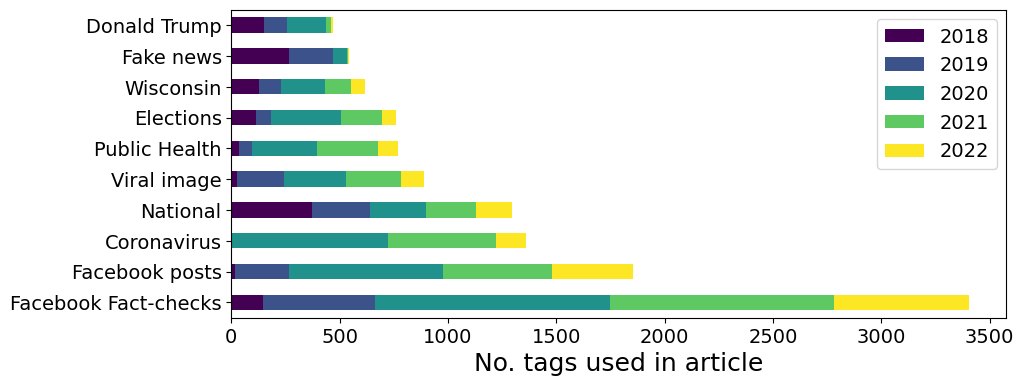

In [94]:
if not os.path.exists(os.getcwd() + '/figs/'):
        os.makedirs(os.getcwd() + '/figs/')

df_temp = data_pf.copy()

df_temp['Year'] = df_temp['Date'].dt.year #make year collumn

tags_by_year = {}

# Extract and count tags used in article by year
for year in df_temp['Year'].unique():
    df_new=df_temp[df_temp['Year']==year]
    tag_values = pd.Series([x for list in df_new['Tags'] for x in list]).value_counts()
    tags_by_year[year] = tag_values #Make dictionary: Key = year. Value is number of tags used in articles 
   

tags_by_year = dict(sorted(tags_by_year.items())) #Sort the dict by year
tag_df = pd.DataFrame(tags_by_year).fillna(0) #Make df of the tag dict and fill NaN as 0

#Extract the top 10 tags in the past five years
top_10_tags = list(tag_df.iloc[:, -5:]\
    .sum(axis=1)\
    .nlargest(10)\
    .index\
    .values)

top_10_tags = tag_df.loc[top_10_tags, :].iloc[:,-5:]

fig1 = top_10_tags.plot(kind='barh', stacked=True, colormap='viridis')
fig1.set_xlabel('No. tags used in article')
plt.savefig('figs/fig1_top_10_tags.pdf', bbox_inches = "tight")

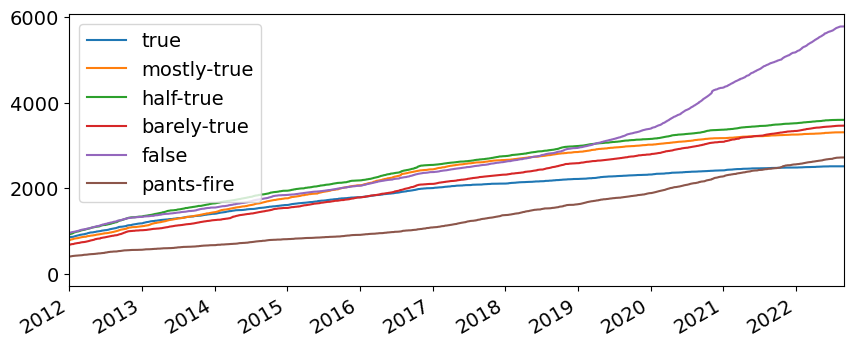

In [95]:
# Drop observations with different scale
df_temp = df_temp[~df_temp['Meter'].isin(['full-flop', 'half-flip', 'no-flip'])]

cat_by_date = {}

# Extract and count tags used in article by date
for date in df_temp['Date'].unique():
    df_new=df_temp[df_temp['Date']==date]
    tag_values = pd.Series(df_new['Meter']).value_counts()
    cat_by_date[date] = tag_values #Make dictionary: Key = date. Value is count of statement classification (pants-on-fire, false, true etc)
   


cat_by_date = dict(sorted(cat_by_date.items())) #Sort the dict by date

reorder_list = ['true', 'mostly-true', 'half-true', 'barely-true', 'false', 'pants-fire'] #define order of sorting to dataframe

df_cat = pd.DataFrame(cat_by_date).fillna(0)
df_cat = df_cat.reindex(reorder_list) #reorder according to above list

df_cat_dev_cuma = df_cat.iloc[:, :]\
    .cumsum(axis=1)

cat_plot = df_cat_dev_cuma.T.iloc[:, :].plot()
cat_plot.set_xlim(pd.Timestamp('2012-01-01'), pd.Timestamp('2022-08-31'))
plt.savefig('figs/fig2.pdf', bbox_inches='tight')

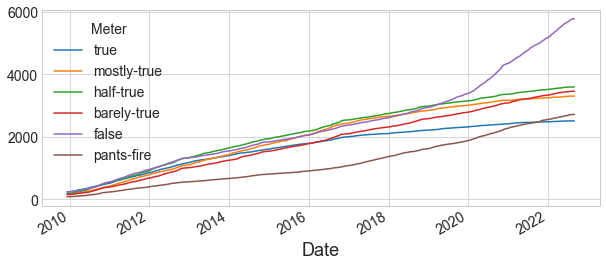

In [36]:
pd.crosstab(index=data_pf['Date'], columns=data_pf['Meter'])\
    .cumsum(axis=0)\
        [['true', 'mostly-true', 'half-true', 'barely-true', 'false', 'pants-fire']]\
            [500:]\
                .plot();

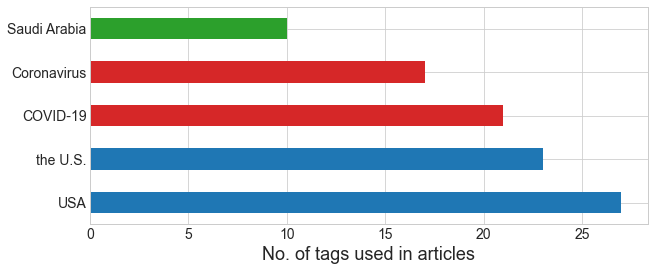

In [38]:
tag_values = pd.Series([x for list in data_pd['Tags'] for x in list]).value_counts()

fig3 = tag_values[:5].plot(kind='barh', color=['tab:blue', 'tab:blue', 'tab:red', 'tab:red', 'tab:green'])
fig3.set_xlabel('No. of tags used in articles')
plt.savefig('figs/fig3_top5tags_pdn.pdf', bbox_inches='tight')

## Analysis

Define functions: 

In [32]:
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score as acc 
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

pd.options.mode.chained_assignment = None
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [12]:
def partition(df, true, fake): 
    
    part = df[df['Meter'].isin(true + fake)]
    part['Fake'] = part['Meter'].isin(fake).astype(int)

    return part

def prepare(document):

    # Lowercase and remove non-alphanumeric characters
    document = document.lower()
    document = re.sub(r'[^\w\s]', ' ', document)

    # Tokenize 
    document_tokens = nltk.tokenize.word_tokenize(document)

    # Delete stop-words
    document_nostop = [i for i in document_tokens if i not in nltk.corpus.stopwords.words('english')]

    # Lemmatize 
    document_lemmatized = [nltk.WordNetLemmatizer().lemmatize(i) for i in document_nostop]
    
    # Covert from list back to string 
    document = ' '.join(document_lemmatized)
    
    return document 

### Partitioning:

In [13]:
part1 = partition(data_pf, ['true'], ['pants-fire'])
X1 = part1['Quote'].apply(prepare).values 
y1 = part1['Fake'].values

part2 = partition(data_pf, ['true', 'mostly-true'], ['pants-fire', 'false'])
X2 = part2['Quote'].apply(prepare).values 
y2 = part2['Fake'].values

part3 = partition(data_pf, ['true', 'mostly-true', 'half-true'], ['pants-fire', 'false', 'barely-true'])
X3 = part3['Quote'].apply(prepare).values 
y3 = part3['Fake'].values

In [14]:
X1_dev, X1_test, y1_dev, y1_test = train_test_split(X1, y1, test_size=1/3, random_state=1337)
X1_train, X1_val1, y1_train, y1_val = train_test_split(X1, y1, test_size=1/2, random_state=1337)

X2_dev, X2_test, y2_dev, y2_test = train_test_split(X2, y2, test_size=1/3, random_state=1337)
X2_train, X2_val, y2_train, y2_val = train_test_split(X2, y2, test_size=1/2, random_state=1337)

X3_dev, X3_test, y3_dev, y3_test = train_test_split(X3, y3, test_size=1/3, random_state=1337)
X3_train, X3_val, y3_train, y3_val = train_test_split(X3, y3, test_size=1/2, random_state=1337)

### Learning curve

In [15]:
pipe = make_pipeline(TfidfVectorizer(), LogisticRegression())

In [16]:
train_sizes1, train_scores1, test_scores1 = \
    learning_curve(estimator=pipe,
                   X=X1_dev,
                   y=y1_dev,
                   train_sizes=np.arange(0.05, 1.05, .05),
                   scoring='accuracy',                 
                   cv=10)

train_sizes2, train_scores2, test_scores2 = \
    learning_curve(estimator=pipe,
                   X=X2_dev,
                   y=y2_dev,
                   train_sizes=np.arange(0.05, 1.05, .05),
                   scoring='accuracy',                 
                   cv=10)

train_sizes3, train_scores3, test_scores3 = \
    learning_curve(estimator=pipe,
                   X=X3_dev,
                   y=y3_dev,
                   train_sizes=np.arange(0.05, 1.05, .05),
                   scoring='accuracy',                 
                   cv=10)

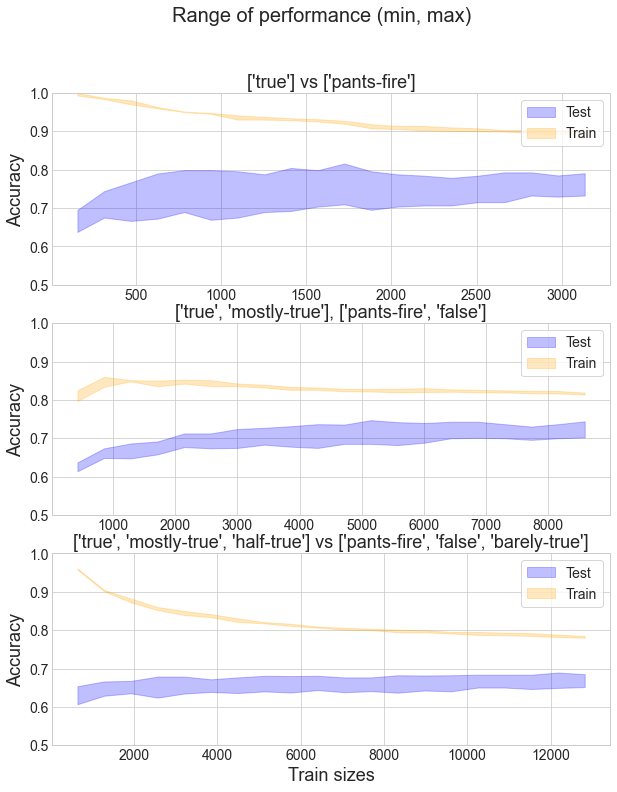

In [17]:
f_learn, ax = plt.subplots(3, 1, figsize=(10, 12))

ax[0].fill_between(train_sizes1, test_scores1.min(1), test_scores1.max(1), alpha=0.25, label ='Test', color='blue')
ax[0].fill_between(train_sizes1, train_scores1.min(1), train_scores1.max(1),  alpha=0.25, label='Train', color='orange')
ax[0].set_title("['true'] vs ['pants-fire']")
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim([0.5,1])
ax[0].legend(frameon=True)

ax[1].fill_between(train_sizes2, test_scores2.min(1), test_scores2.max(1), alpha=0.25, label ='Test', color='blue')
ax[1].fill_between(train_sizes2, train_scores2.min(1), train_scores2.max(1),  alpha=0.25, label='Train', color='orange')
ax[1].set_title("['true', 'mostly-true'], ['pants-fire', 'false']")
ax[1].set_ylabel('Accuracy')
ax[1].set_ylim([0.5,1])
ax[1].legend(frameon=True)

ax[2].fill_between(train_sizes3, test_scores3.min(1), test_scores3.max(1), alpha=0.25, label ='Test', color='blue')
ax[2].fill_between(train_sizes3, train_scores3.min(1), train_scores3.max(1),  alpha=0.25, label='Train', color='orange')
ax[2].set_title("['true', 'mostly-true', 'half-true'] vs ['pants-fire', 'false', 'barely-true']")
ax[2].set_ylabel('Accuracy')
ax[2].set_ylim([0.5,1])
ax[2].set_xlabel('Train sizes')
ax[2].legend(frameon=True)


f_learn.suptitle('Range of performance (min, max)');

### Validation curve:

In [33]:
lambdas = np.logspace(-4, 4, 50)
Cs = 1/lambdas 



train_scores1_vc, test_scores1_vc = \
    validation_curve(estimator=pipe,
                     X=X1_dev,
                     y=y1_dev,
                     param_name='logisticregression__C', #built-in name of hyperparameter
                     param_range=lambdas, #values to consider
                     scoring='accuracy',                 
                     cv=10)

train_scores2_vc, test_scores2_vc = \
    validation_curve(estimator=pipe,
                     X=X2_dev,
                     y=y2_dev,
                     param_name='logisticregression__C', #built-in name of hyperparameter
                     param_range=lambdas, #values to consider
                     scoring='accuracy',                 
                     cv=10)

train_scores3_vc, test_scores3_vc = \
    validation_curve(estimator=pipe,
                     X=X3_dev,
                     y=y3_dev,
                     param_name='logisticregression__C', #built-in name of hyperparameter
                     param_range=lambdas, #values to consider
                     scoring='accuracy',                 
                     cv=10)                 

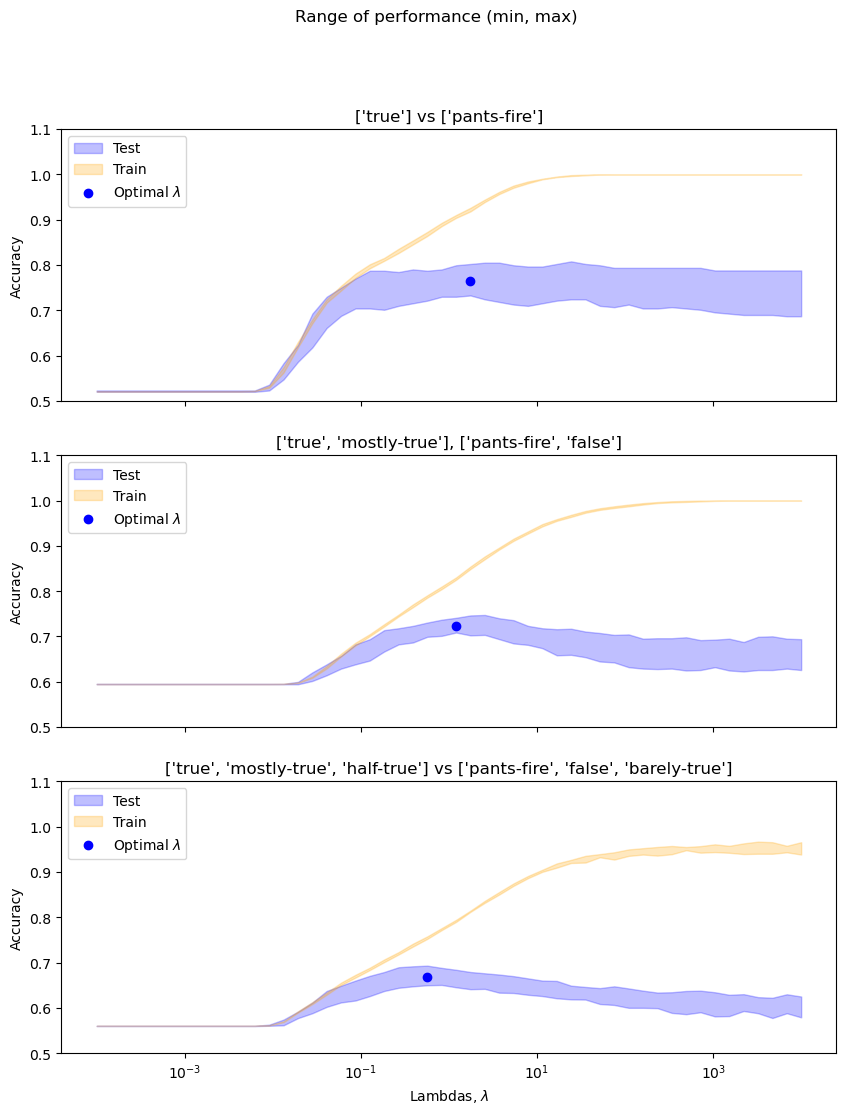

In [29]:
best_acc1 = max(test_scores1_vc.mean(axis=1))
best_lambda1 = lambdas[np.where(test_scores1_vc.mean(axis=1) == best_acc1)]
best_acc2 = max(test_scores2_vc.mean(axis=1))
best_lambda2 = lambdas[np.where(test_scores2_vc.mean(axis=1) == best_acc2)]
best_acc3 = max(test_scores3_vc.mean(axis=1))
best_lambda3 = lambdas[np.where(test_scores3_vc.mean(axis=1) == best_acc3)]

f_learn, ax = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

ax[0].fill_between(lambdas, test_scores1_vc.min(1), test_scores1_vc.max(1), alpha=0.25, label ='Test', color='blue')
ax[0].fill_between(lambdas, train_scores1_vc.min(1), train_scores1_vc.max(1),  alpha=0.25, label='Train', color='orange')
ax[0].scatter(best_lambda1, best_acc1, label='Optimal $\lambda$', color='blue')
ax[0].set_title("['true'] vs ['pants-fire']")
ax[0].set_ylabel('Accuracy')
ax[0].set_ylim([0.5,1.1])
ax[0].set_xscale('log')
ax[0].legend(loc='upper left', frameon=True)

ax[1].fill_between(lambdas, test_scores2_vc.min(1), test_scores2_vc.max(1), alpha=0.25, label ='Test', color='blue')
ax[1].fill_between(lambdas, train_scores2_vc.min(1), train_scores2_vc.max(1),  alpha=0.25, label='Train', color='orange')
ax[1].scatter(best_lambda2, best_acc2, label='Optimal $\lambda$', color='blue')
ax[1].set_title("['true', 'mostly-true'], ['pants-fire', 'false']")
ax[1].set_ylabel('Accuracy')
ax[1].set_ylim([0.5,1.1])
ax[1].set_xscale('log')
ax[1].legend(loc='upper left', frameon=True)

ax[2].fill_between(lambdas, test_scores3_vc.min(1), test_scores3_vc.max(1), alpha=0.25, label ='Test', color='blue')
ax[2].fill_between(lambdas, train_scores3_vc.min(1), train_scores3_vc.max(1),  alpha=0.25, label='Train', color='orange')
ax[2].scatter(best_lambda3, best_acc3, label='Optimal $\lambda$', color='blue')
ax[2].set_title("['true', 'mostly-true', 'half-true'] vs ['pants-fire', 'false', 'barely-true']")
ax[2].set_ylabel('Accuracy')
ax[2].set_ylim([0.5,1.1])
ax[2].set_xscale('log')
ax[2].set_xlabel('Lambdas, $\lambda$')
ax[2].legend(loc='upper left', frameon=True)


f_learn.suptitle('Range of performance (min, max)');

### Topic modelling - peacedata.net

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer(stop_words='english', max_df=0.1, max_features=5000)
bag = count.fit_transform(data_pd['Article'].values)

from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=5,random_state=123) #The random_state parameter pass an integer that makes the result reproducible 
review_topics = lda.fit_transform(bag)

n_top_words = 5
word_names = count.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_): #lda.components_ stores a matrix containing the word importance for each topic
    print("Topic %d:" % (topic_idx + 1))
    print(" ".join([word_names[i]
    for i in topic.argsort()\
        [:-n_top_words - 1:-1]]))

Topic 1:
turkey journalists immigration migrants qaeda
Topic 2:
yemen assange britain coalition eu
Topic 3:
fox mau sexual kenya exarcheia
Topic 4:
muslims henderson opcw pakistan hong
Topic 5:
amazon adani color gas project
